In [94]:
%load_ext autoreload
%autoreload 2
import zipfile
import os
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from ensembles import RandomForestMSE, GradientBoostingMSE
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Эксперимент 1

Проведите предобработку имеющихся данных. Разделите данные на обучение и контроль, переведите данные в numpy.ndarray . Опишите выполненную предобработку данных в отчёте.

In [21]:
!gdown 1evfn1oUzRLy0yrF8H0MNRuVE4mfm7gRf

Downloading...
From: https://drive.google.com/uc?id=1evfn1oUzRLy0yrF8H0MNRuVE4mfm7gRf
To: /content/kc_house_data.csv.zip
100% 798k/798k [00:00<00:00, 113MB/s]


In [22]:
with zipfile.ZipFile('/content/kc_house_data.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kc_house_data')

In [23]:
data = pd.read_csv('/content/kc_house_data/kc_house_data.csv', index_col=0)

In [24]:
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [25]:
nan_rows = data[data.isnull().any(axis=1)]
len(nan_rows)

0

In [26]:
data['year'] = pd.to_datetime(data['date']).dt.year
data['month'] = pd.to_datetime(data['date']).dt.month
data['dayofyear'] = pd.to_datetime(data['date']).dt.dayofyear
data['dayofmonth'] = pd.to_datetime(data['date']).dt.day
data['dayofweek'] = pd.to_datetime(data['date']).dt.dayofweek
data = data.drop(['date'], axis=1)

In [27]:
target = data['price'].values
features = np.array(data.drop('price', axis=1), dtype=float)

In [28]:
target.shape

(21613,)

In [29]:
features.shape

(21613, 23)

In [30]:
X_train, X_test_test, y_train, y_test_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [31]:
data.nunique()

price            4028
bedrooms           13
bathrooms          30
sqft_living      1038
sqft_lot         9782
floors              6
waterfront          2
view                5
condition           5
grade              12
sqft_above        946
sqft_basement     306
yr_built          116
yr_renovated       70
zipcode            70
lat              5034
long              752
sqft_living15     777
sqft_lot15       8689
year                2
month              12
dayofyear         356
dayofmonth         31
dayofweek           7
dtype: int64

# Эксперимент 2

Исследуйте поведение алгоритма случайный лес. Изучите зависимость RMSE на отложенной выборке
и время работы алгоритма в зависимости от следующих факторов:
* количество деревьев в ансамбле
* размерность подвыборки признаков для одного дерева
* максимальная глубина дерева (дополнительно разберите случай, когда глубина неограничена)

# Размерность подвыборки признаков

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [35]:
feature_subsample_sizes = np.arange(1, 24, 2)

np.random.seed(42)
rf_size_history_error = np.zeros(len(feature_subsample_sizes))
rf_size_history_time = np.zeros(len(feature_subsample_sizes))

for i, feature_subsample_size in tqdm(enumerate(feature_subsample_sizes)):
  n_iters = 10
  for _ in range(n_iters):
    model = RandomForestMSE(feature_subsample_size=feature_subsample_size)
    start = time.time()
    rf_size_history_error[i] += model.fit(X_train, y_train, X_test, y_test)[-1]
    end = time.time()
    rf_size_history_time[i] += end - start

  rf_size_history_error[i] /= n_iters
  rf_size_history_time[i] /= n_iters

12it [06:54, 34.58s/it]


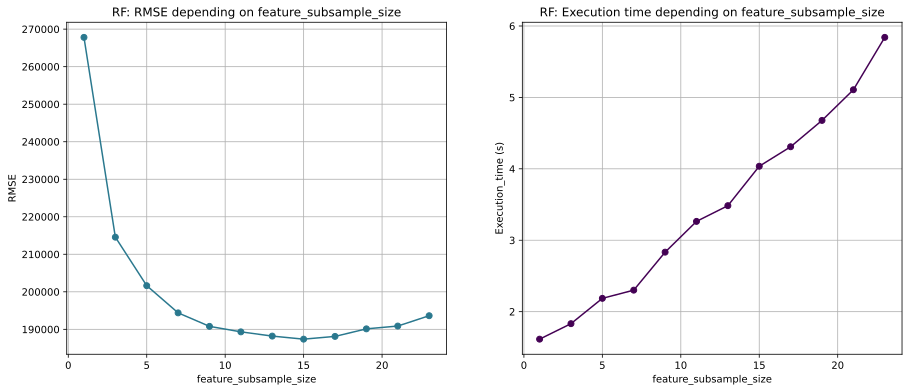

In [38]:
plt.rcParams['axes.grid'] = True

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in [0., 0.4, 0.7, 0.9]][::-1]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(feature_subsample_sizes, rf_size_history_error, color=colors[2], marker='o')
plt.title(f'RF: RMSE depending on feature_subsample_size')
plt.xlabel('feature_subsample_size')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(feature_subsample_sizes, rf_size_history_time, color=colors[3], marker='o')
plt.title(f'RF: Execution time depending on feature_subsample_size')
plt.xlabel('feature_subsample_size')
plt.ylabel('Execution_time (s)')

plt.margins(x=0.05, y=0.05)
plt.savefig("rf_size.svg", bbox_inches='tight')
plt.show()

In [41]:
best_rf_feature_subsample_size = feature_subsample_sizes[np.argmin(rf_size_history_error)]
best_rf_feature_subsample_size

15

# Максимальная глубина дерева

In [74]:
max_depths = np.arange(1, 20, 2)
max_depths = np.append(max_depths, None)

np.random.seed(42)
rf_max_depth_history_error = np.zeros(len(max_depths))
rf_max_depth_history_time = np.zeros(len(max_depths))

for i, max_depth in tqdm(enumerate(max_depths)):

  n_iters = 5
  for _ in range(n_iters):
    model = RandomForestMSE(max_depth=max_depth, feature_subsample_size=best_rf_feature_subsample_size)

    history = model.fit(X_train, y_train, X_test, y_test)
    rf_max_depth_history_error[i] += history['error'][-1]
    rf_max_depth_history_time[i] += np.sum(history['time'])

  rf_max_depth_history_error[i] /= n_iters
  rf_max_depth_history_time[i] /= n_iters

11it [16:26, 89.70s/it] 


In [75]:
max_depths[max_depths == None] = 'Unlimited'
max_depths = max_depths.astype(str)

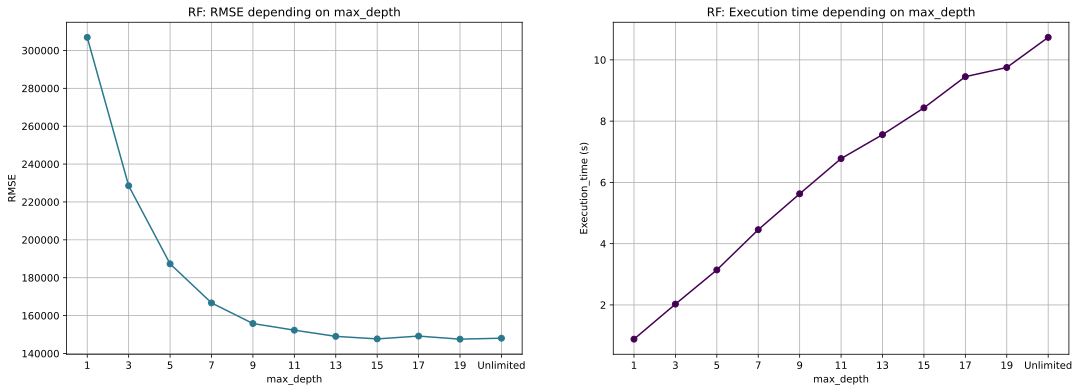

In [76]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(max_depths, rf_max_depth_history_error, color=colors[2], marker='o')
plt.title(f'RF: RMSE depending on max_depth')
plt.xlabel('max_depth')
plt.xticks([0, 4, 8, 12, 16, 20, 24])
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(max_depths, rf_max_depth_history_time, color=colors[3], marker='o')
plt.title(f'RF: Execution time depending on max_depth')
plt.xlabel('max_depth')
# plt.xticks([0, 4, 9, 14, 19, 25])
plt.ylabel('Execution_time (s)')

plt.margins(x=0.05, y=0.05)
plt.savefig("rf_max_depth.svg", bbox_inches='tight')
plt.show()

In [78]:
best_rf_max_depth = int(max_depths[np.argmin(rf_max_depth_history_error)])
best_rf_max_depth

19

# Количество деревьев

In [84]:
n_estimators = 500

np.random.seed(42)
rf_n_estimators_history_error = np.zeros(n_estimators)
rf_n_estimators_history_time = np.zeros(n_estimators)

n_iters = 1
for _ in range(n_iters):
  model = RandomForestMSE(n_estimators=n_estimators, max_depth=best_rf_max_depth, feature_subsample_size=best_rf_feature_subsample_size)

  history = model.fit(X_train, y_train, X_test, y_test)
  rf_n_estimators_history_error += history['error']
  rf_n_estimators_history_time += np.cumsum(history['time'])

rf_n_estimators_history_error /= n_iters
rf_n_estimators_history_time /= n_iters

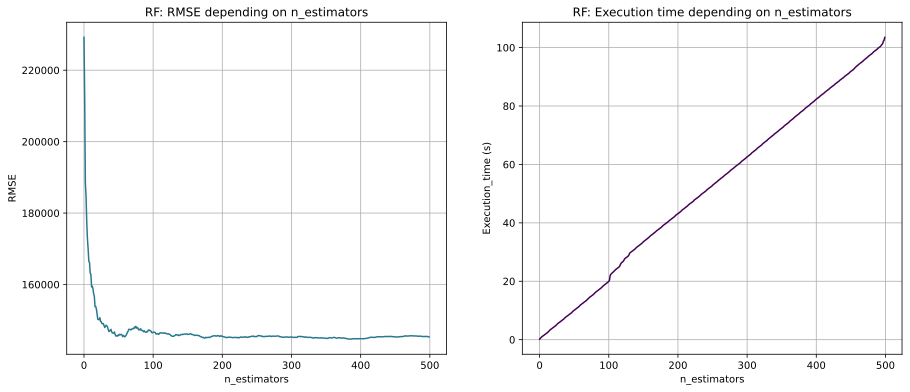

In [92]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(rf_n_estimators_history_error, color=colors[2])
plt.title(f'RF: RMSE depending on n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(rf_n_estimators_history_time, color=colors[3])
plt.title(f'RF: Execution time depending on n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Execution_time (s)')

plt.margins(x=0.05, y=0.05)
plt.savefig("rf_n_estimators.svg", bbox_inches='tight')
plt.show()

In [86]:
best_rf_n_estimators = np.argmin(rf_n_estimators_history_error)
best_rf_n_estimators

385

# Эксперимент 3

Исследуйте поведение алгоритма градиентный бустинг. Изучите зависимость RMSE на отложенной
выборке и время работы алгоритма в зависимости от следующих факторов:
* количество деревьев в ансамбле
* размерность подвыборки признаков для одного дерева
* максимальная глубина дерева (дополнительно разберите случай, когда глубина неограничена)
* выбранный learning_rate (каждый новый алгоритм добавляется в композицию с коэффициентом
α · learning_rate )

Замечание: Для исследования зависимости от количества деревьев не обязательно с нуля переобучать
модель.

learning_rates

In [95]:
learning_rates = np.logspace(-4, 0, 10)

np.random.seed(42)
gb_lr_history_error = np.zeros(len(learning_rates))
gb_lr_history_time = np.zeros(len(learning_rates))

for i, learning_rate in tqdm(enumerate(learning_rates)):
  n_iters = 5
  for _ in range(n_iters):
    model = GradientBoostingMSE(learning_rate=learning_rate)

    history = model.fit(X_train, y_train, X_test, y_test)
    gb_lr_history_error[i] += history['error'][-1]
    gb_lr_history_time[i] += np.sum(history['time'])

  gb_lr_history_error[i] /= n_iters
  gb_lr_history_time[i] /= n_iters

10it [03:37, 21.73s/it]


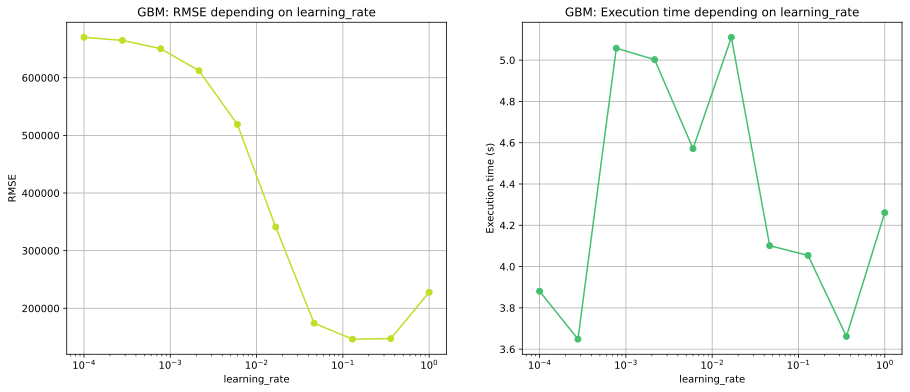

In [97]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(learning_rates, gb_lr_history_error, color=colors[0], marker='o')
plt.title(f'GBM: RMSE depending on learning_rate')
plt.xlabel('learning_rate')
plt.xscale('log')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(learning_rates, gb_lr_history_time, color=colors[1], marker='o')
plt.title(f'GBM: Execution time depending on learning_rate')
plt.xlabel('learning_rate')
plt.xscale('log')
plt.ylabel('Execution time (s)')

plt.margins(x=0.05, y=0.05)
plt.savefig("gbm_lr.svg", bbox_inches='tight')
plt.show()

In [98]:
best_gb_learning_rate = learning_rates[np.argmin(gb_lr_history_error)]
best_gb_learning_rate

0.12915496650148828

In [ ]:
feature_subsample_sizes = np.arange(1, 24, 2)

np.random.seed(42)
gb_size_history_error = np.zeros(len(feature_subsample_sizes))
gb_size_history_time = np.zeros(len(feature_subsample_sizes))

for i, feature_subsample_size in tqdm(enumerate(feature_subsample_sizes)):
  n_iters = 5
  for _ in range(n_iters):
    model = GradientBoostingMSE(feature_subsample_size=feature_subsample_size, learning_rate=best_gb_learning_rate)
    start = time.time()
    gb_size_history_error[i] += model.fit(X_train, y_train, X_test, y_test)['error'][-1]
    end = time.time()
    gb_size_history_time[i] += end - start

  gb_size_history_error[i] /= n_iters
  gb_size_history_time[i] /= n_iters

15it [04:29, 22.61s/it]

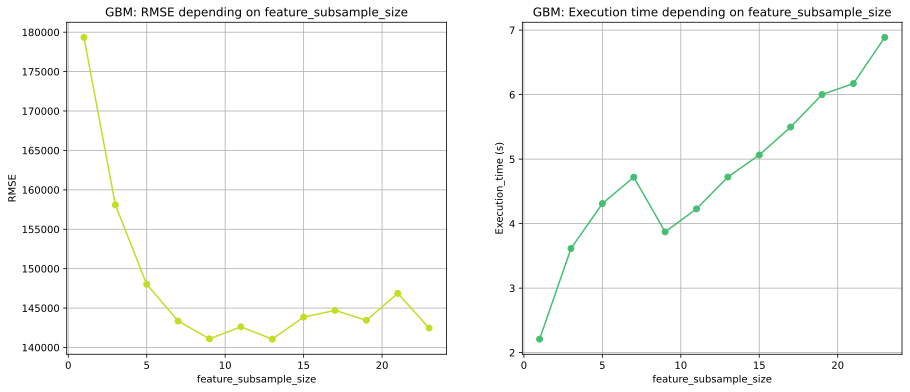

In [103]:
plt.rcParams['axes.grid'] = True
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(feature_subsample_sizes, gb_size_history_error, color=colors[0], marker='o')
plt.title(f'GBM: RMSE depending on feature_subsample_size')
plt.xlabel('feature_subsample_size')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(feature_subsample_sizes, gb_size_history_time, color=colors[1], marker='o')
plt.title(f'GBM: Execution time depending on feature_subsample_size')
plt.xlabel('feature_subsample_size')
plt.ylabel('Execution_time (s)')

plt.margins(x=0.05, y=0.05)
plt.savefig("gbm_size.svg", bbox_inches='tight')
plt.show()

In [104]:
best_gb_feature_subsample_size = feature_subsample_sizes[np.argmin(gb_size_history_error)]
best_gb_feature_subsample_size

13

# Максимальная глубина

In [105]:
max_depths = np.arange(1, 20, 2)
max_depths = np.append(max_depths, None)

np.random.seed(42)
gb_max_depth_history_error = np.zeros(len(max_depths))
gb_max_depth_history_time = np.zeros(len(max_depths))

for i, max_depth in tqdm(enumerate(max_depths)):

  n_iters = 5
  for _ in range(n_iters):
    model = GradientBoostingMSE(max_depth=max_depth, feature_subsample_size=best_gb_feature_subsample_size, learning_rate=best_gb_learning_rate)

    history = model.fit(X_train, y_train, X_test, y_test)
    gb_max_depth_history_error[i] += history['error'][-1]
    gb_max_depth_history_time[i] += np.sum(history['time'])

  gb_max_depth_history_error[i] /= n_iters
  gb_max_depth_history_time[i] /= n_iters

11it [08:21, 45.59s/it]


In [106]:
max_depths[max_depths == None] = 'Unlimited'
max_depths = max_depths.astype(str)

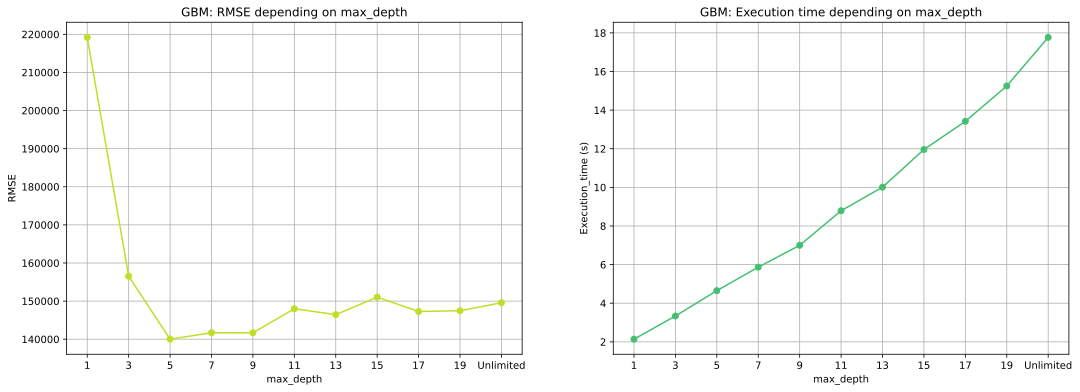

In [112]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(max_depths, gb_max_depth_history_error, color=colors[0], marker='o')
plt.title(f'GBM: RMSE depending on max_depth')
plt.xlabel('max_depth')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(max_depths, gb_max_depth_history_time, color=colors[1], marker='o')
plt.title(f'GBM: Execution time depending on max_depth')
plt.xlabel('max_depth')
plt.ylabel('Execution_time (s)')

plt.margins(x=0.05, y=0.05)
plt.savefig("gbm_max_depth.svg", bbox_inches='tight')
plt.show()

In [108]:
best_gb_max_depth = int(max_depths[np.argmin(gb_max_depth_history_error)])
best_gb_max_depth

5

# Количество деревьев

In [110]:
n_estimators = 500

np.random.seed(42)
gb_n_estimators_history_error = np.zeros(n_estimators)
gb_n_estimators_history_time = np.zeros(n_estimators)

n_iters = 1
for _ in range(n_iters):
  model = GradientBoostingMSE(n_estimators=n_estimators, max_depth=best_gb_max_depth, feature_subsample_size=best_gb_feature_subsample_size, learning_rate=best_gb_learning_rate)

  history = model.fit(X_train, y_train, X_test, y_test)
  gb_n_estimators_history_error += history['error']
  gb_n_estimators_history_time += np.cumsum(history['time'])

gb_n_estimators_history_error /= n_iters
gb_n_estimators_history_time /= n_iters

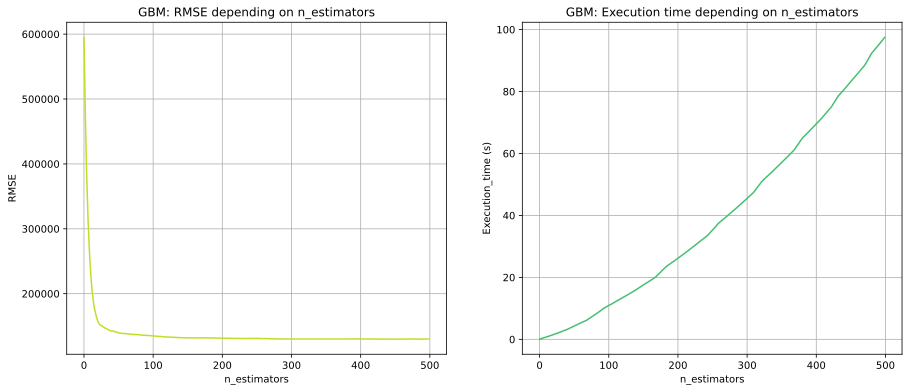

In [113]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(gb_n_estimators_history_error, color=colors[0])
plt.title(f'GBM: RMSE depending on n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.plot(gb_n_estimators_history_time, color=colors[1])
plt.title(f'GBM: Execution time depending on n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Execution_time (s)')

plt.margins(x=0.05, y=0.05)
plt.savefig("gbm_n_estimators.svg", bbox_inches='tight')
plt.show()

# Лучшие алгоритмы

In [115]:
gbm = GradientBoostingMSE(n_estimators=300, max_depth=best_gb_max_depth, feature_subsample_size=best_gb_feature_subsample_size, learning_rate=best_gb_learning_rate)
gbm_hist = gbm.fit(X_train, y_train, X_test_test, y_test_test)
gbm_hist['error'][-1]

133070.4098894847

In [116]:
rf = RandomForestMSE(n_estimators=300, max_depth=best_rf_max_depth, feature_subsample_size=best_rf_feature_subsample_size)
rf_hist = rf.fit(X_train, y_train, X_test_test, y_test_test)
rf_hist['error'][-1]

145244.07513016457